In [21]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [22]:
from collections import Counter
import numpy as np
from scipy.stats import beta, uniform

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

Implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with known class-conditional densities and known prevalence
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
- Platt scaling
- Isotonic regression
- Temperature scaling
4. Evaluate the calibration curves on the full base dataset: which come closest to recovering the correct prevalence estimate

## 1 Intrinsic data generator

### 1.1 Generate dataset

In [23]:
def generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    num_pos_item = int(p_pos * num_base_size)
    num_neg_item = num_base_size - num_pos_item

    scores_of_pos_items = pos_density_rv.generate_data(num_pos_item)
    scores_of_neg_items = neg_density_rv.generate_data(num_neg_item)

    items = []
    gt_label_dict = {}
    item_idx = 0

    for score in scores_of_pos_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'pos'
        item_idx += 1
    
    for score in scores_of_neg_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'neg'
        item_idx += 1

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [ ]:
pos_density_rv = MixtureCUD(components=[beta(10, 2), uniform(0, 1)], weights=[1, 0])
neg_density_rv = MixtureCUD(components=[beta(2, 5), uniform(0, 1)], weights=[1, 0])

p_pos = 0.1

num_base_size = 10000
num_bin = 10

In [25]:
intrinsic_base_dataset, intrinsic_gt_label_dict = generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size)

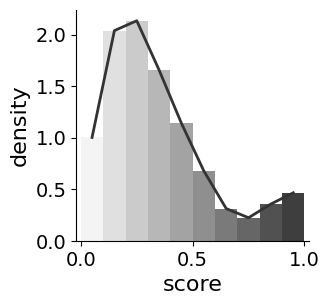

In [26]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=10)
intrinsic_base_dataset.classifier_score_distribution.plot()

In [27]:
# ground truth prevalence
Counter(intrinsic_gt_label_dict.values())["pos"] / num_base_size

0.1

### 1.2 Subsample calibration sample

In [28]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

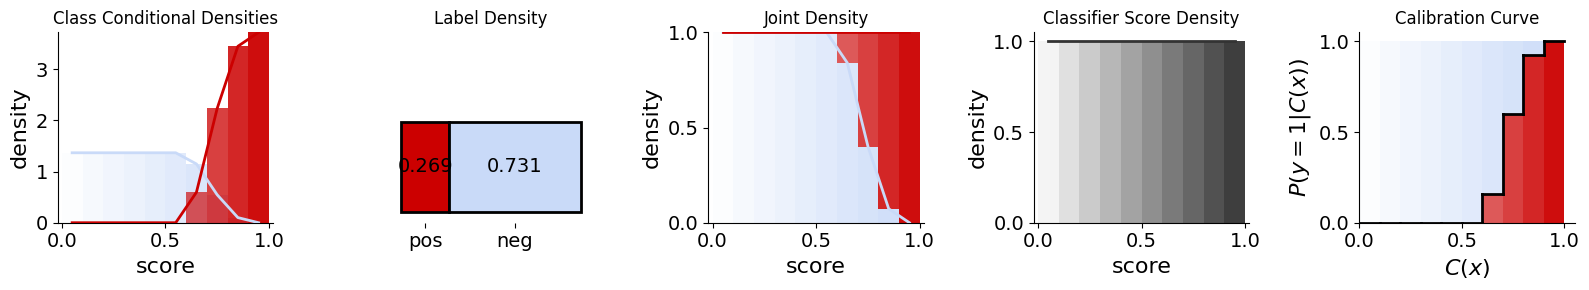

In [29]:
# 2. Select a subset of the dataset and annotate the labels
intrinsic_selected_dataset, intrinsic_selection_weights = (
    intrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    intrinsic_gt_label_dict[uid]
    for uid in intrinsic_selected_dataset.df["uid"].values.astype(int)
]
intrinsic_selected_dataset.annotate_sample(annotated_labels)

intrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [30]:
intrinsic_selected_dataset.df.head(10)

uid gt_label     p_pos     p_neg
bin                                          
0   7319  7319.0      neg  0.051780  0.948220
    8787  8787.0      neg  0.086741  0.913259
    8616  8616.0      neg  0.036749  0.963251
    7363  7363.0      neg  0.067448  0.932552
    7208  7208.0      neg  0.038918  0.961082
    6978  6978.0      neg  0.069441  0.930559
    6879  6879.0      neg  0.072730  0.927270
    3255  3255.0      neg  0.080125  0.919875
    6245  6245.0      neg  0.056249  0.943751
    9113  9113.0      neg  0.097098  0.902902

In [31]:
binning_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [32]:
intrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = intrinsic_selected_dataset.calibration_curve

# estimated_w, estimated_b = ps_calibration_curve.get_params()
# estimated_w = estimated_w.item()
# estimated_b = estimated_b.item()

# print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

Accuracy of each fold: [0.69, 0.7133333333333334, 0.7366666666666667, 0.75, 0.7666666666666667]
c=0.01, avg_acc=0.7313333333333334
Accuracy of each fold: [0.9066666666666666, 0.9166666666666666, 0.92, 0.92, 0.92]
c=0.1, avg_acc=0.9166666666666666
Accuracy of each fold: [0.9333333333333333, 0.92, 0.9533333333333334, 0.9633333333333334, 0.95]
c=1, avg_acc=0.944
Accuracy of each fold: [0.9366666666666666, 0.92, 0.95, 0.9633333333333334, 0.95]
c=10, avg_acc=0.944
Accuracy of each fold: [0.9366666666666666, 0.92, 0.9533333333333334, 0.9633333333333334, 0.95]
c=100, avg_acc=0.9446666666666668
best_c=100, best_avg_acc=0.9446666666666668


In [33]:
intrinsic_selected_dataset.update_calibration_curve(method="temperature scaling")
temperature_calibration_curve = intrinsic_selected_dataset.calibration_curve

[[0.05178017 0.94821983]
 [0.08674126 0.91325874]
 [0.03674924 0.96325076]
 [0.06744839 0.93255161]
 [0.03891848 0.96108152]
 [0.06944095 0.93055905]
 [0.07273045 0.92726955]
 [0.08012503 0.91987497]
 [0.0562489  0.9437511 ]
 [0.09709834 0.90290166]]
[0 0 0 0 0 0 0 0 0 0]
10.0
0.7131607846910929
[[0.05178017 0.94821983]
 [0.03674924 0.96325076]
 [0.06744839 0.93255161]
 [0.06944095 0.93055905]
 [0.07273045 0.92726955]
 [0.0562489  0.9437511 ]
 [0.09709834 0.90290166]
 [0.06944095 0.93055905]
 [0.09281684 0.90718316]
 [0.02016509 0.97983491]]
[0 0 0 0 0 0 0 0 0 0]
10.0
0.7136516058239626
[[0.08674126 0.91325874]
 [0.03674924 0.96325076]
 [0.03891848 0.96108152]
 [0.07273045 0.92726955]
 [0.08012503 0.91987497]
 [0.0562489  0.9437511 ]
 [0.09709834 0.90290166]
 [0.06944095 0.93055905]
 [0.09281684 0.90718316]
 [0.02016509 0.97983491]]
[0 0 0 0 0 0 0 0 0 0]
10.0
0.7110418984102121
[[0.05178017 0.94821983]
 [0.08674126 0.91325874]
 [0.06744839 0.93255161]
 [0.03891848 0.96108152]
 [0.06944

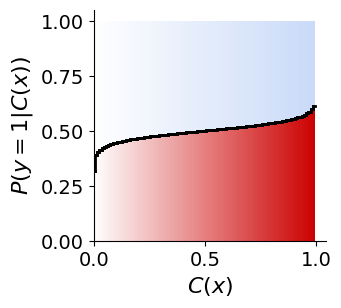

In [34]:
temperature_calibration_curve.plot()

In [35]:
temperature_calibration_curve.get_calibrated_prob(temperature_calibration_curve.x_axis)

array([0.31863754, 0.3882718 , 0.40452118, 0.41437571, 0.42152627,
       0.42717262, 0.43185901, 0.43587917, 0.4394099 , 0.442566  ,
       0.44542624, 0.44804709, 0.45047037, 0.45272798, 0.45484478,
       0.45684055, 0.45873128, 0.4605301 , 0.4622479 , 0.46389384,
       0.46547572, 0.46700019, 0.46847301, 0.46989919, 0.47128313,
       0.47262871, 0.47393935, 0.47521814, 0.47646783, 0.4776909 ,
       0.47888961, 0.480066  , 0.48122196, 0.48235921, 0.48347934,
       0.48458383, 0.48567406, 0.48675129, 0.48781675, 0.48887156,
       0.48991681, 0.49095352, 0.49198266, 0.49300517, 0.49402196,
       0.4950339 , 0.49604183, 0.4970466 , 0.49804902, 0.49904989,
       0.50005   , 0.50105015, 0.50205114, 0.50305375, 0.5040588 ,
       0.5050671 , 0.50607949, 0.50709681, 0.50811994, 0.5091498 ,
       0.51018731, 0.51123347, 0.5122893 , 0.51335588, 0.51443436,
       0.51552595, 0.51663194, 0.51775372, 0.51889276, 0.52005069,
       0.52122923, 0.52243028, 0.5236559 , 0.52490839, 0.52619

In [36]:
intrinsic_selected_dataset.update_calibration_curve(method="mid piecewise linear")
mid_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [37]:
intrinsic_selected_dataset.update_calibration_curve(method="mean piecewise linear")
mean_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [38]:
intrinsic_selected_dataset.update_calibration_curve(method="isotonic regression")
isotonic_calibration_curve = intrinsic_selected_dataset.calibration_curve

### 1.4 Show plots, including Prevalence estimation

In [39]:
labels = ['pos', 'neg']

estimated prevalence: 0.09786133333333333
[0.         0.         0.         0.         0.         0.
 0.16       0.6        0.92666667 1.         1.        ]
estimated prevalence: 0.09785421902280804
[0.         0.         0.         0.         0.         0.
 0.08       0.38       0.76333333 0.96333333 1.        ]
estimated prevalence: 0.09848721654998177
[0.         0.         0.         0.         0.         0.
 0.08957487 0.38876246 0.75897644 0.96466039 1.        ]
estimated prevalence: 0.09834630897623178
[2.60216416e-08 2.84051140e-07 3.10068231e-06 3.38458851e-05
 3.69336392e-04 4.01695011e-03 4.21691892e-02 3.24590382e-01
 8.39898178e-01 9.82837156e-01 9.98402829e-01]
estimated prevalence: 0.09835036482255854
[0.         0.         0.         0.         0.         0.
 0.         0.25       0.86419753 1.         1.        ]


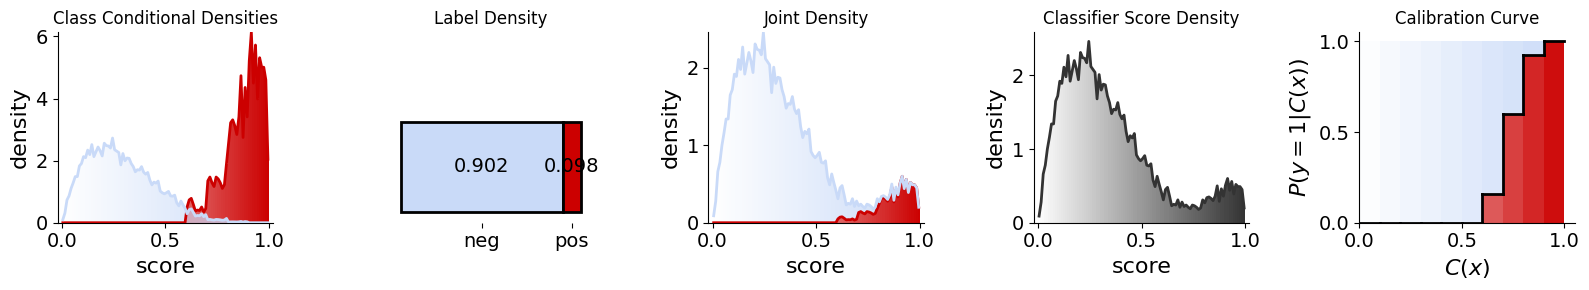

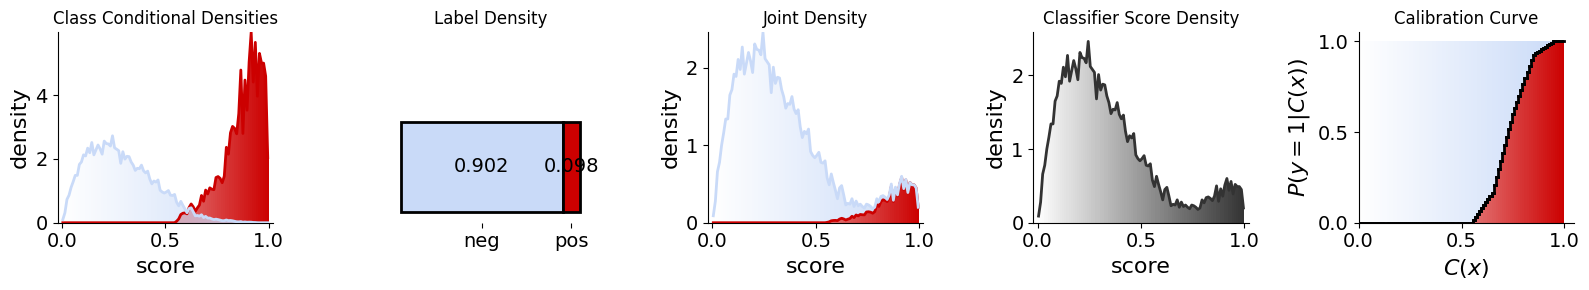

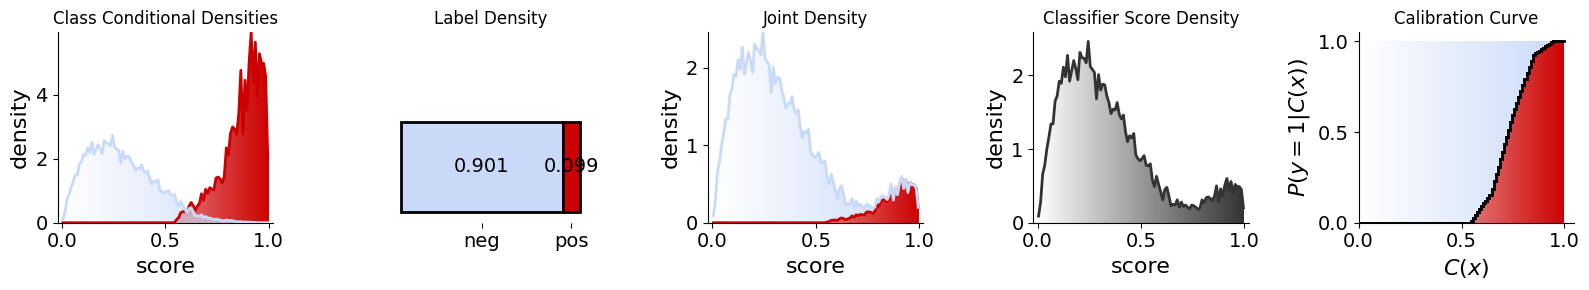

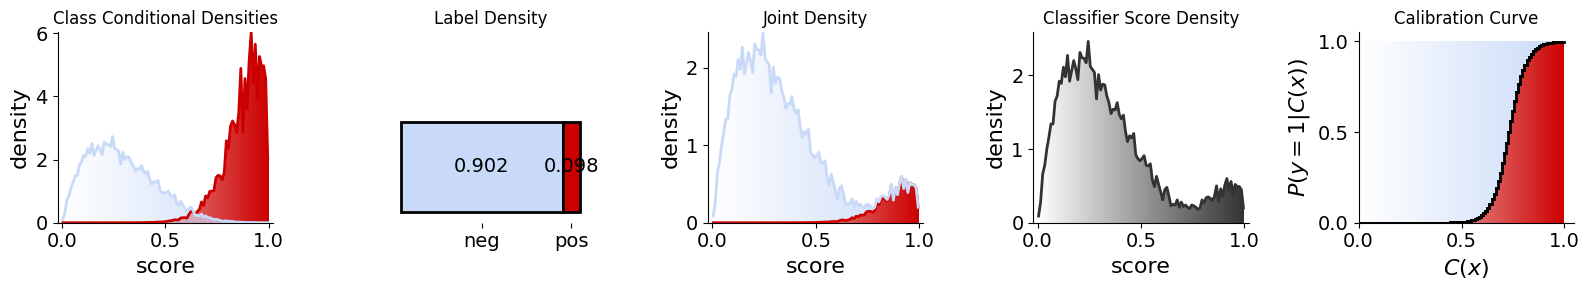

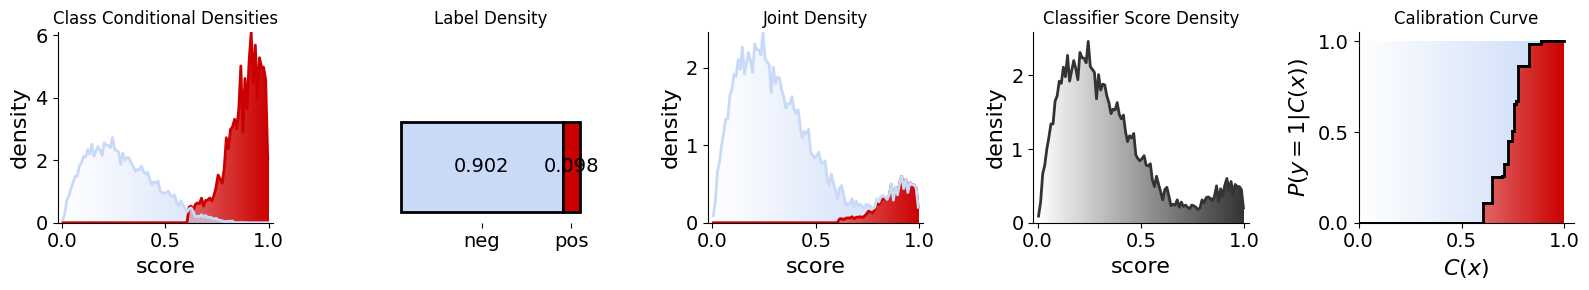

In [40]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=100)

for cc in [
    binning_calibration_curve,
    mid_piecewise_linear_calibration_curve,
    mean_piecewise_linear_calibration_curve,
    ps_calibration_curve,
    # temperature_calibration_curve,
    isotonic_calibration_curve,
]:
    jd = ExtrinsicJointDistribution(labels, intrinsic_base_dataset.classifier_score_distribution, cc)
    print('estimated prevalence:', intrinsic_base_dataset.extrinsic_estimate(calibration_curve=cc))
    print(cc.get_calibrated_prob(np.linspace(0, 1, 11)))
    jd.plot_five_distributions()